In [109]:
# TODO scrape any car data from ss.com
# clean up prices as numerics
# group by make and model
# plot the data - pricing for sure

In [110]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [111]:
url = "https://www.ss.com/en/transport/cars/dacia/sell/"

In [112]:
req = requests.get(url)
req.status_code

200

In [113]:
soup = BeautifulSoup(req.text, 'lxml')
soup.title

<title>SS.COM Cars - Dacia, Prices, Sell - Advertisements</title>

In [114]:
tables = soup.find_all("table")
headline = soup.find("tr", {"id":"head_line"})
headtds = headline.find_all("td")
headline.text
headtds[0].text

'\n\xa0Advertisements\r\n\n\n\ndate\n'

In [115]:
headcolumns = [el.text for el in headtds[1:]]
headcolumns

['Model', 'Year', 'Volume', 'Run', 'Price']

In [116]:
def getColList(soup):
    column_list = ["description","url"] # we decided to that we need these two column names no matter the html
    headline = soup.find("tr", {"id":"head_line"})
    headtds = headline.find_all("td")
    headcolumns = [el.text for el in headtds[1:]] # this will get all column names starting with 2nd in HTML
    column_list += headcolumns
    return column_list

In [117]:
column_names = getColList(soup)
column_names

['description', 'url', 'Model', 'Year', 'Volume', 'Run', 'Price']

In [118]:
trows = soup.find_all('tr')

In [119]:
rows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]

In [120]:
def getRowList(soup):
    trows = soup.find_all('tr')
    aprows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]
    return aprows

In [121]:
rows = getRowList(soup)

In [122]:
first_ad = rows[0]

In [123]:
row_tds = first_ad.find_all('td')

In [124]:
def getRow(row,colist=column_names):
    row_tds = row.find_all('td')
    rowDict = {}
    if len(row_tds) < 3: # a little sanity check
        print("Hmm bad row")
        return rowDict
    
    rowDict[colist[0]] = row_tds[2].text # so the big assumption is that we always get description in 3rd column
    rowDict[colist[1]] = "https://ss.com" + row_tds[1].find('a').get('href')
    for td,key in zip(row_tds[3:],colist[2:]): 
        rowDict[key] = td.text
    return rowDict

In [125]:
getRow(rows[6])

{'description': 'Dacia Sandero Stepway Tce 100zs, benzīns/Lpg gāze, 6mt, komplektācija Comfor',
 'url': 'https://ss.com/msg/en/transport/cars/dacia/sandero/bllnek.html',
 'Model': 'Sandero',
 'Year': '2022',
 'Volume': '1.0',
 'Run': '6.5 thd.',
 'Price': '17,660  €'}

In [126]:
def getRows(rowlist,colist=column_names):
    return [getRow(row, colist=colist) for row in rowlist]

In [127]:
def getDFfromURL(url):
    
    req = requests.get(url)
    if req.status_code != 200:
        print("Request Fail with", req.status_code)
        return None 
    soup = BeautifulSoup(req.text, 'lxml')
    column_names = getColList(soup)
    rowlist = getRowList(soup)
    rows = getRows(rowlist,colist=column_names)
    return pd.DataFrame(rows, columns=column_names)

In [128]:
cars_dacia = url
idf = getDFfromURL(cars_dacia)
idf.head()

,description,url,Model,Year,Volume,Run,Price
0,"Mašīna teicamā kartībā, ekonomiska (degvielas ...",https://ss.com/msg/en/transport/cars/dacia/san...,Sandero,2022,1.0,14 thd.,"15,600 €"
1,Automašīna no Vācijas Latvijā netika izmantota...,https://ss.com/msg/en/transport/cars/dacia/dus...,Duster,2013,1.6,121 thd.,"7,490 €"
2,1.5 dīzelis 81kw. 4x4 pilnpiediņa. Auto pirkts...,https://ss.com/msg/en/transport/cars/dacia/dus...,Duster,2012,1.5D,237 thd.,"5,900 €"
3,Automašīna braucamā stāvoklī ar manāmiem defek...,https://ss.com/msg/en/transport/cars/dacia/log...,Logan,2006,1.6,110 thd.,600 €
4,Jaunais Dacia Jogger LE Extreme 110Tce 7-seats...,https://ss.com/msg/en/transport/cars/dacia/ano...,Another,2022,1.0,5,"23,200 €"


In [139]:
idf.to_csv("cars_dacia_20221023.csv")

In [130]:
dacia_df = pd.read_csv(r"C:\Users\dovil\Desktop\she goes tech\SGT\cars_dacia_20221023.csv")
dacia_df_ed = dacia_df.copy


In [131]:
dacia_df['Price'] = dacia_df['Price'].str.replace("€","")
dacia_df['Price'] = dacia_df['Price'].str.replace(",","")
dacia_df.Price.head()
dacia_df['Price'] = pd.to_numeric(dacia_df['Price'], errors='coerce')

pd.options.display.float_format = '{:,.2f}'.format
dacia_df['Price'].describe()

count       30.00
mean     8,930.43
std      6,252.51
min        600.00
25%      4,248.75
50%      6,699.50
75%     14,687.50
max     23,200.00
Name: Price, dtype: float64

In [132]:
dacia_df.groupby(['Year']).describe()['Price']

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2006,1.00,600.00,NaN,600.00,600.00,600.00,600.00,600.00
2007,2.00,"1,270.00",169.71,"1,150.00","1,210.00","1,270.00","1,330.00","1,390.00"
2008,2.00,"3,000.00","2,121.32","1,500.00","2,250.00","3,000.00","3,750.00","4,500.00"
2010,2.00,"3,455.00","1,081.87","2,690.00","3,072.50","3,455.00","3,837.50","4,220.00"
2011,3.00,"5,961.67","1,640.63","4,235.00","5,192.50","6,150.00","6,825.00","7,500.00"
2012,1.00,"5,900.00",NaN,"5,900.00","5,900.00","5,900.00","5,900.00","5,900.00"
2013,4.00,"5,735.00","1,789.94","3,600.00","4,612.50","5,925.00","7,047.50","7,490.00"
2014,1.00,"4,290.00",NaN,"4,290.00","4,290.00","4,290.00","4,290.00","4,290.00"
2015,2.00,"5,974.50",741.76,"5,450.00","5,712.25","5,974.50","6,236.75","6,499.00"


In [133]:
dacia_df['Run'] = dacia_df['Run'].str.replace("thd.","")
dacia_df['Run'] = pd.to_numeric(dacia_df['Run'], errors='coerce')
dacia_df.groupby(['Year']).describe()['Run']

C:\Users\dovil\AppData\Local\Temp\ipykernel_24504\4162443445.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  dacia_df['Run'] = dacia_df['Run'].str.replace("thd.","")


,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2006,1.00,110.00,NaN,110.00,110.00,110.00,110.00,110.00
2007,1.00,236.00,NaN,236.00,236.00,236.00,236.00,236.00
2008,2.00,128.50,38.89,101.00,114.75,128.50,142.25,156.00
2010,1.00,235.00,NaN,235.00,235.00,235.00,235.00,235.00
2011,1.00,244.00,NaN,244.00,244.00,244.00,244.00,244.00
2012,1.00,237.00,NaN,237.00,237.00,237.00,237.00,237.00
2013,4.00,133.00,54.06,79.00,110.50,122.50,145.00,208.00
2014,1.00,142.00,NaN,142.00,142.00,142.00,142.00,142.00
2015,2.00,180.00,43.84,149.00,164.50,180.00,195.50,211.00


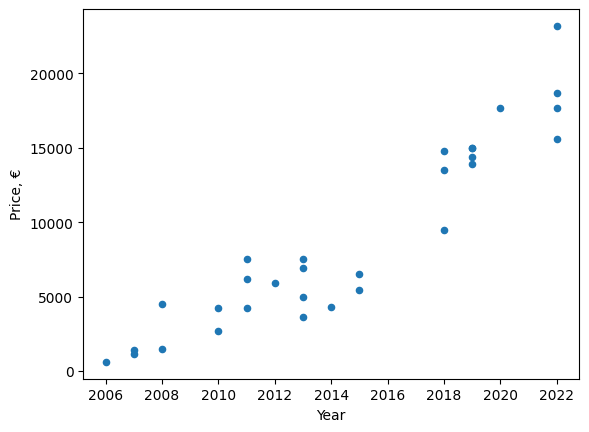

In [134]:

dacia_df_price = dacia_df.sort_values(['Year'], ascending=[True])
dacia_df_price = pd.DataFrame(dacia_df_price,columns=['Year','Price'])
dacia_df_price.plot(x ='Year', y='Price', kind = 'scatter')
plt.ylabel('Price, \u20ac')
plt.show()


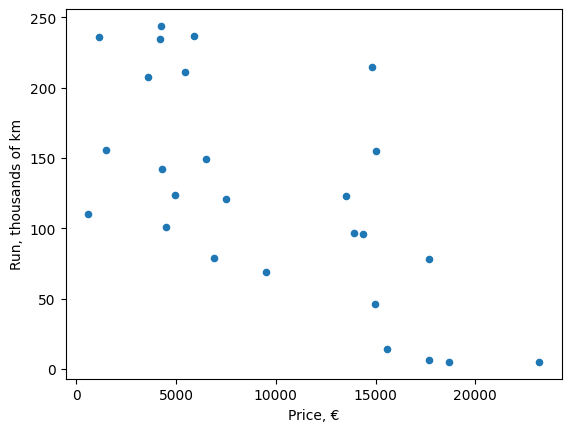

In [135]:
dacia_df_run = dacia_df.sort_values(['Run'], ascending=[True])
dacia_df_run = pd.DataFrame(dacia_df_run,columns=['Run','Price'])
dacia_df_run.plot(x ='Price', y='Run', kind = 'scatter')
plt.ylabel('Run, thousands of km')
plt.xlabel('Price, \u20ac')
plt.show()

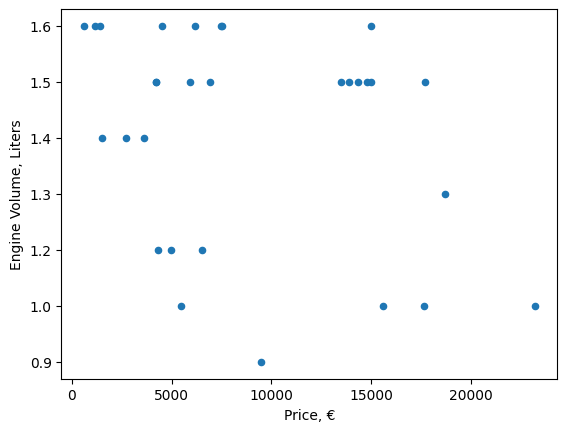

In [140]:
dacia_df['Volume'] = dacia_df['Volume'].str.replace("D","")
dacia_df['Volume'] = dacia_df['Volume'].str.replace("B","")
dacia_df_volume = dacia_df.sort_values(['Volume'], ascending=[True])
df = pd.DataFrame(dacia_df_volume,columns=['Volume','Price'])
df.plot(x ='Price', y='Volume', kind = 'scatter')
plt.xlabel('Price, \u20ac')
plt.ylabel('Engine Volume, Liters')
plt.show()

In [141]:
dacia_df_price.columns

Index(['Year', 'Price'], dtype='object')

Text(0.5, 1.0, 'Price, €')

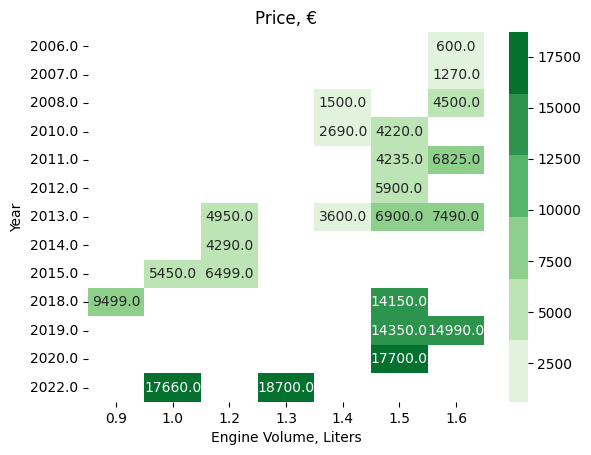

In [145]:
dacia_map = dacia_df[['Year', 'Volume', 'Run', 'Price']]
dacia_map = dacia_map.astype({'Year':'float'})
dacia_map.head()

dacia_table = dacia_map.pivot_table(index='Year', columns='Volume', values='Price', aggfunc=np.median)
dacia_table
plt.figure()
colormap = sns.color_palette("Greens")
ax = sns.heatmap(data=dacia_table, cmap=colormap, annot=True, fmt='.1f')
ax.set_xlabel('Engine Volume, Liters')
ax.set_title('Price, \u20ac')